# estimation of attraction coefficient
Tim Tyree<br>
10.7.2022

In [2]:
from IPython.display import clear_output
clear_output(wait=True)

import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

os.chdir(nb_dir)
from lib import *

# import cupy, cudf
# from lib.rapids_func import *

import seaborn as sns
import matplotlib.ticker as mtick

from lib.model.attraction_sim_anneal_fit import comp_square_error_msr_aff_osc_period_fixed
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

In [3]:
# !pwd

In [4]:
# from scipy.optimize import minimize
from scipy.optimize import dual_annealing

In [5]:
plt.close()
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [6]:
from lib.model import comp_square_error_msr_aff_osc_period_fixed_with_msr_offset

# define module

## TODO: see which method of averaging $R_i(t')$ results in alinear values similar to expected

In [46]:
###########################
# mean min lifetime: Gamma
###########################
tscale=1e-3 #s per ms
lifetime_fk= 105.3 # (1.6) ms
lifetime_lr= 33.37 # (73) ms
Gamma_fk = lifetime_fk*tscale
Gamma_lr = lifetime_lr*tscale

In [47]:
#alinear from simulated annealing
alinear_expected_fk = 1.9252  #cm^2/s
alinear_expected_lr = 11.2437 #cm^2/s
print(f"{alinear_expected_fk=:.4f} cm^2/s")
print(f"{alinear_expected_lr=:.4f} cm^2/s")

alinear_expected_fk=1.9252 cm^2/s
alinear_expected_lr=11.2437 cm^2/s


In [48]:
#load annihilation range timeseries
range_data_dir_fk='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'
range_data_dir=range_data_dir_fk
data_lst=load_from_pickle(range_data_dir)
num_termination_events = len(data_lst)
print(f"loaded range timeseries from {len(data_lst)} termination events")
df_fk=pd.concat(data_lst)
del data_lst
print(f"{df_fk.shape=}")

range_data_dir_lr='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl'
range_data_dir=range_data_dir_lr
data_lst=load_from_pickle(range_data_dir)
num_termination_events = len(data_lst)
print(f"loaded range timeseries from {len(data_lst)} termination events")
df_lr=pd.concat(data_lst)
del data_lst
print(f"{df_lr.shape=}")
df_fk['Rsq']=df_fk['R']**2
df_lr['Rsq']=df_lr['R']**2
df_fk['model']='Fenton-Karma'
df_lr['model']='Luo-Rudy'
df_concat = pd.concat([df_fk,df_lr])
df_concat.reset_index(inplace=True)

loaded range timeseries from 80 termination events
df_fk.shape=(3846532, 9)
loaded range timeseries from 595 termination events
df_lr.shape=(524869, 9)


In [49]:
random_state=42
num_sample=1000
#use seaborn to scatter plot R vs. Rsq vs. tdeath 

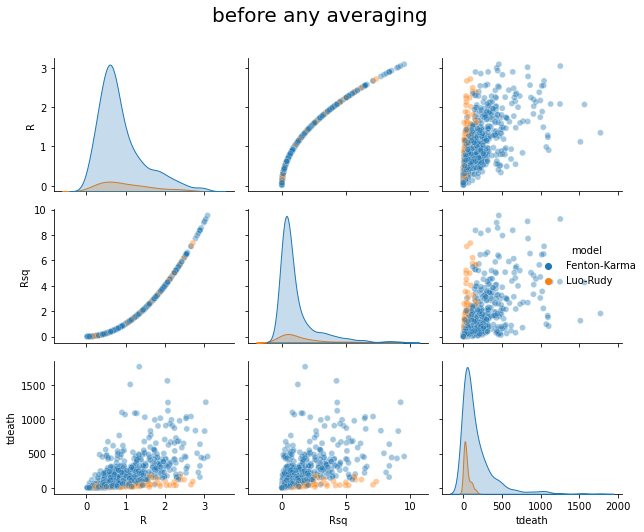

In [55]:
#plot kinematic statistics
sig = sns.pairplot(df_concat.sample(num_sample,random_state=random_state), 
                   vars=["R", "Rsq", 'tdeath'],
                   diag_kind="kde",
                   hue='model',plot_kws={'alpha':0.4})
plt.suptitle('before any averaging\n',fontsize=20)
# plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
#GOAL: search for single particle alinear estimator

In [135]:
#TODO: compute the averages of everything all together at once

# TODO: bootstrap all R values together
# comp_mean_bootstrap_uncertainty

In [136]:
Gamma=Gamma_fk
df = df_fk

# Gamma=Gamma_lr
# df = df_lr

meanR,Delta_meanR,num_obsR,p_normalR=comp_mean_bootstrap_uncertainty(df['R'].values)
printing=True
if printing:
    print(f"mean range (all positions together): {meanR:.4f} +/- {Delta_meanR:.4f} cm (N={num_obsR}, {p_normalR=:.4f})")

meanSR,Delta_meanSR,num_obsSR,p_normalSR=comp_mean_bootstrap_uncertainty(df['R'].values**2)
if printing:
    print(f"mean squared range (all positions together): {meanSR:.4f} +/- {Delta_meanSR:.4f} cm^2 (N={num_obsSR}, {p_normalSR=:.4f})")

meantdeath,Delta_meantdeath,num_obstdeath,p_normaltdeath=comp_mean_bootstrap_uncertainty(df['tdeath'].values)
if printing:
    print(f"mean tdeath (all positions together): {meantdeath:.4f} +/- {Delta_meantdeath:.4f} ms (N={num_obstdeath}, {p_normaltdeath=:.4f})")
    

mean range (all positions together): 0.9022 +/- 0.0006 cm (N=3846532, p_normalR=0.3041)
mean squared range (all positions together): 1.1521 +/- 0.0015 cm^2 (N=3846532, p_normalSR=0.0369)
mean tdeath (all positions together): 176.4914 +/- 0.2236 ms (N=3846532, p_normaltdeath=0.9583)


In [81]:
# meantdeath


In [87]:
# alinear_boe = meanR**2/(4.*meantdeath*1e-3) #cm^2/s --> 6.226 cm^2/s for LR
# alinear_boe = meanR**2/(4.*Gamma) #cm^2/s # --> 8.63 cm^2/s for LR, Q: does this work for LR?
# alinear_boe = meanSR/(4.*meantdeath*1e-3) #cm^2/s --> 8.67 cm^2/s for LR
alinear_boe = meanSR/(4.*Gamma) #cm^2/s # --> 12.02 cm^2/s, should work for LR ***

# alinear_boe = meanR**2/(4.*meantdeath*1e-3) #cm^2/s --> 1.153 cm^2/s for FK
# alinear_boe = meanR**2/(4.*Gamma) #cm^2/s # --> 1.932 cm^2/s for FK, should really work for FK ***
# alinear_boe = meanSR/(4.*meantdeath*1e-3) #cm^2/s --> 1.632 cm^2/s for FK
# alinear_boe = meanSR/(4.*Gamma) #cm^2/s # --> 2.735 cm^2/s, Q: does this work for FK?
# print(f"{alinear_boe=:.4} cm^2/s")
print(f"{alinear_boe=:.4} cm^2/s for FK")

alinear_boe=2.735 cm^2/s for FK


In [ ]:
# meanSR/(4.*Gamma)

In [56]:
#TODO(failing ^this): compute the time averaged dataframe and then average the events all together
# - TODO: compute alinear on a single particle basis
#HINT: alinear_boe = meanSR/(4.*Gamma) #cm^2/s # --> 12.02 cm^2/s, should work for LR ***

#DONT(failing ^this): compute the average the events all together and then compute the time average
#NOTE: ^this should be numerically equivalent to the E_Gamma[MSR(t')] evaluate.

In [221]:
#compute single particle alinear estimates
tscale=1e-3 #s per ms
DT = float(df['tdeath'].drop_duplicates().sort_values()[:2].diff().tail(1)) #ms per frame
DT*=tscale

# df=df_fk.copy()
# alinear_expected = float(alinear_expected_fk)
df=df_concat.copy()
# df.sort_values(by=['trial_num','annihilation_index','tdeath'])
# for (trial_num,annihilation_index),g in df.groupby(by=['trial_num','annihilation_index']):
dict_lst=[]
df.sort_values(by=['model','trial_num','annihilation_index','tdeath'])
for (model_name,trial_num,annihilation_index),g in df.groupby(by=['model','trial_num','annihilation_index']):
    minR=g["R"].min()
    maxR=g["R"].max()
    meanR=g["R"].mean()
    meanSR=g["Rsq"].mean()
    lifetime=g['tdeath'].max()*tscale
    lifetime+=DT #correct for zero indexing
    if model_name=='Fenton-Karma':
        Gamma=float(Gamma_fk)
    elif model_name=='Luo-Rudy':
        Gamma=float(Gamma_fk)
    else:
        print(f"Warning: model unrecognized: {model_name}")
    
    a_boe_R = meanR**2/(4.*lifetime) #cm^2/s
    a_boe_SR = meanSR/(4.*lifetime) #cm^2/s    
#     a_boe_R = meanR**2/(4.*Gamma) #cm^2/s  #invariably lowers the mean...
#     a_boe_SR = meanSR/(4.*Gamma) #cm^2/s   #invariably lowers the mean...
    
    dict_out=dict(
        model=model_name,trial_num=trial_num,annihilation_index=annihilation_index,
        a_boe_R=a_boe_R,
        a_boe_SR=a_boe_SR,
        meanR=meanR,
        meanSR=meanSR,
        lifetime=lifetime,
        minR=minR,
        maxR=maxR,
    )
    #record
    dict_lst.append(dict_out)


In [222]:
df_events=pd.DataFrame(dict_lst)
df_events.head()

,model,trial_num,annihilation_index,a_boe_R,a_boe_SR,meanR,meanSR,lifetime,minR,maxR
0,Fenton-Karma,0,0,0.918620,1.025788,0.624095,0.434934,0.106,0.308869,1.463100
1,Fenton-Karma,0,1,0.984906,1.017826,0.498193,0.256492,0.063,0.100062,0.571424
2,Fenton-Karma,0,2,2.475389,2.686192,1.071719,1.246393,0.116,0.067082,2.108486
3,Fenton-Karma,0,3,1.848631,1.884839,0.734711,0.550373,0.073,0.158528,1.009387
4,Fenton-Karma,0,4,4.877319,6.064410,0.241925,0.072773,0.003,0.092195,0.384269


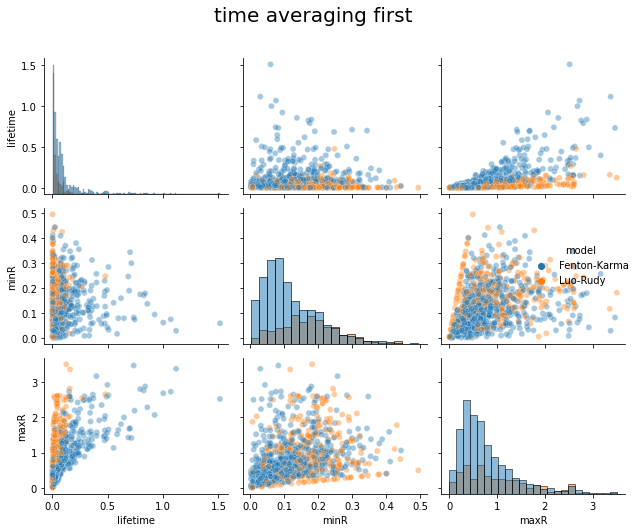

In [223]:
num_sample=1000
# num_sample=5000
#plot kinematic statistics
sig = sns.pairplot(df_events.sample(num_sample,random_state=random_state), 
                   vars=['lifetime','minR','maxR'],
#                    vars=["meanR",'a_boe_R','lifetime',"a_boe_SR","meanSR",'minR','maxR'],
#                    vars=["meanR",'a_boe_R','lifetime',"a_boe_SR","meanSR"],
                   diag_kind="hist",#="kde",
                   hue='model',plot_kws={'alpha':0.4})
plt.suptitle('time averaging first\n',fontsize=20)
plt.tight_layout()
plt.show()

In [224]:
#compute the particle average alinear_R,SR and average lifetime values
descr_fk = df_events[df_events['model']=='Fenton-Karma'].describe()[['lifetime','a_boe_SR','a_boe_R']]
descr_lr = df_events[df_events['model']=='Luo-Rudy'].describe()[['lifetime','a_boe_SR','a_boe_R']]

print(f"Ensemble averages for Fenton-Karma:")
print(descr_fk.loc[['mean','std','count']])

print(f"\nEnsemble averages for Luo-Rudy:")
print(descr_lr.loc[['mean','std','count']])

Ensemble averages for Fenton-Karma:
           lifetime      a_boe_SR       a_boe_R
mean       0.106320      2.145042      1.916151
std        0.162272      3.645949      3.250890
count  36179.000000  36179.000000  36179.000000

Ensemble averages for Luo-Rudy:
           lifetime      a_boe_SR       a_boe_R
mean       0.034366      8.128457      7.212652
std        0.045084      8.291920      7.568733
count  15273.000000  15273.000000  15273.000000


observation for the LR model: the mean and std of both boe alinear estimates and lifetime are roughly the same. this supports exponential distributions for the LR model.

__Results: The Full Models Are Not Ergodic In Apparent Attraction Coefficient__

observation: SR boe estimator from both full models are significantly different when integrating over time before vs. after ensemble averaging.

<AxesSubplot:xlabel='lifetime', ylabel='a_boe_R'>

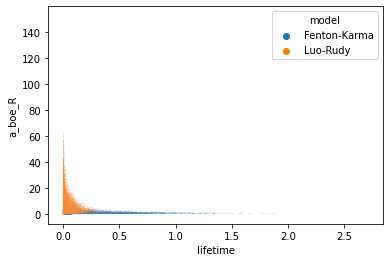

In [225]:
sns.scatterplot(x='lifetime', y='a_boe_R', hue='model', #ax=ax,
                data=df_events, **kwargs_scatter)
#plot second radial moments

Demonstration of non-ergodicity:
alinear_expected_fk=1.9252 cm^2/s (black)
alinear_expected_lr=11.2437 cm^2/s (red)
symbols indicate ensemble averages for (blue) FK and (orange) LR.
indicated are estimators from (circles) mean range and (squares) mean squared range (pun intended).


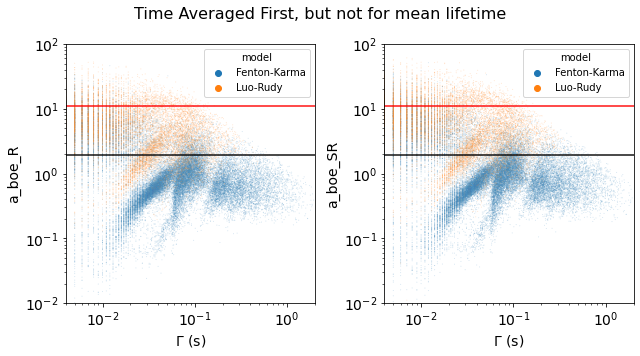

In [226]:
#show non-ergodicity
print(f"Demonstration of non-ergodicity:")
kwargs_scatter=dict(style=None, s=1,#10,#size=10, palette=None, hue_order=None, hue_norm=None, 
                #sizes=None, size_order=None, size_norm=None, 
                #markers=True, style_order=None, x_bins=None, y_bins=None, 
                #units=None, estimator=None, ci=95, n_boot=1000, 
                alpha=0.2, x_jitter=None, y_jitter=None, legend='auto')

use_loglog=True
fontsize=14

#plot the desired kinematic statistics panels on a log-log axis for both full models
#indicating expected alinear versus lifetime for both of the full models on a loglog plot
fig,axs=plt.subplots(figsize=(9,5),ncols=2)
#plot first radial moments
ax=axs[0] 
sns.scatterplot(x='lifetime', y='a_boe_R', hue='model', ax=ax,
                data=df_events, **kwargs_scatter)
#plot second radial moments
ax=axs[1] 
sns.scatterplot(x='lifetime', y='a_boe_SR', hue='model', ax=ax,
                data=df_events, **kwargs_scatter)
#plot alinear expected from simulated annealing
alinear_expected_fk = 1.9252  #cm^2/s
alinear_expected_lr = 11.2437 #cm^2/s
# alinear_expected_fk = 1.9252  -0.2#cm^2/s  # --> adj for D has little effect 
# alinear_expected_lr = 11.2437 -0.8#cm^2/s  # --> adj for D has little effect 
xv=np.logspace(-3,1.1,100)
axs[0].plot(xv,0.*xv+alinear_expected_fk,'k-',lw=2,alpha=0.7)
axs[0].plot(xv,0.*xv+alinear_expected_lr,'r-',lw=2,alpha=0.7)
axs[1].plot(xv,0.*xv+alinear_expected_fk,'k-',lw=2,alpha=0.7)
axs[1].plot(xv,0.*xv+alinear_expected_lr,'r-',lw=2,alpha=0.7)
print(f"{alinear_expected_fk=:.4f} cm^2/s (black)")
print(f"{alinear_expected_lr=:.4f} cm^2/s (red)")

#plot the ensemble averages
print(f"symbols indicate ensemble averages for (blue) FK and (orange) LR.")
print(f"indicated are estimators from (circles) mean range and (squares) mean squared range (pun intended).")
# for ax in axs:
# # / Gamma    
#     ax.scatter([0.106320],[2.145042],c='C0',marker='s',s=40,alpha=0.7) #FK #SR
#     ax.scatter([0.034366],[8.128457],c='C1',marker='s',s=40,alpha=0.7) #LR #SR
#     ax.scatter([0.106320],[1.916151],c='C0',marker='o',s=40,alpha=0.7) #FK #R
#     ax.scatter([0.034366],[7.212652],c='C1',marker='o',s=40,alpha=0.7) #LR #R
# # / lifetime    
# #     ax.scatter([0.106320],[2.145042],c='C0',marker='s',s=40,alpha=0.7) #FK #SR
# #     ax.scatter([0.034366],[8.128457],c='C1',marker='s',s=40,alpha=0.7) #LR #SR
# #     ax.scatter([0.106320],[1.916151],c='C0',marker='o',s=40,alpha=0.7) #FK #R
# #     ax.scatter([0.034366],[7.212652],c='C1',marker='o',s=40,alpha=0.7) #LR #R

#format plot
format_plot(ax=axs[0],xlabel=r'$\Gamma$ (s)',ylabel=r'a_boe_R', use_loglog=use_loglog, fontsize=fontsize)
format_plot(ax=axs[1],xlabel=r'$\Gamma$ (s)',ylabel=r'a_boe_SR', use_loglog=use_loglog, fontsize=fontsize)
# plt.tight_layout()
axs[0].axis([4e-3,2,1e-2,1e2])
axs[1].axis([4e-3,2,1e-2,1e2])
# fig.suptitle('Time Averaged First',fontsize=fontsize+2)
fig.suptitle('Time Averaged First, but not for mean lifetime',fontsize=fontsize+2)
plt.tight_layout()
plt.show()

All Observations Averaged Together Agrees Better:
alinear_expected_fk=1.9252 cm^2/s (black)
alinear_expected_lr=11.2437 cm^2/s (red)
symbols indicate overall averages for (blue) FK and (orange) LR.
indicated are estimators from (circles) mean range and (squares) mean squared range (pun intended).


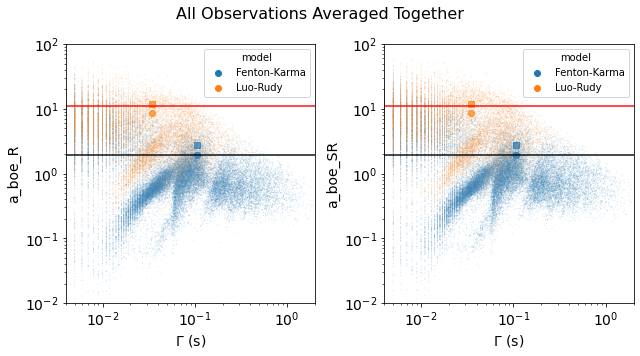

In [228]:
#TODO: substitute those first "all-together" averages in a new plot
#heretim
#show non-ergodicity
print(f"All Observations Averaged Together Agrees Better:")
kwargs_scatter=dict(style=None, s=1,#10,#size=10, palette=None, hue_order=None, hue_norm=None, 
                #sizes=None, size_order=None, size_norm=None, 
                #markers=True, style_order=None, x_bins=None, y_bins=None, 
                #units=None, estimator=None, ci=95, n_boot=1000, 
                alpha=0.2, x_jitter=None, y_jitter=None, legend='auto')

use_loglog=True
fontsize=14

#plot the desired kinematic statistics panels on a log-log axis for both full models
#indicating expected alinear versus lifetime for both of the full models on a loglog plot
fig,axs=plt.subplots(figsize=(9,5),ncols=2)
#plot first radial moments
ax=axs[0] 
sns.scatterplot(x='lifetime', y='a_boe_R', hue='model', ax=ax,
                data=df_events, **kwargs_scatter)
#plot second radial moments
ax=axs[1] 
sns.scatterplot(x='lifetime', y='a_boe_SR', hue='model', ax=ax,
                data=df_events, **kwargs_scatter)
#plot alinear expected from simulated annealing
alinear_expected_fk = 1.9252  #cm^2/s
alinear_expected_lr = 11.2437 #cm^2/s
# alinear_expected_fk = 1.9252  -0.2#cm^2/s  # --> adj for D has little effect 
# alinear_expected_lr = 11.2437 -0.8#cm^2/s  # --> adj for D has little effect 
xv=np.logspace(-3,1.1,100)
axs[0].plot(xv,0.*xv+alinear_expected_fk,'k-',lw=2,alpha=0.7)
axs[0].plot(xv,0.*xv+alinear_expected_lr,'r-',lw=2,alpha=0.7)
axs[1].plot(xv,0.*xv+alinear_expected_fk,'k-',lw=2,alpha=0.7)
axs[1].plot(xv,0.*xv+alinear_expected_lr,'r-',lw=2,alpha=0.7)
print(f"{alinear_expected_fk=:.4f} cm^2/s (black)")
print(f"{alinear_expected_lr=:.4f} cm^2/s (red)")

#plot the ensemble averages
print(f"symbols indicate overall averages for (blue) FK and (orange) LR.")
print(f"indicated are estimators from (circles) mean range and (squares) mean squared range (pun intended).")
for ax in axs:
    ax.scatter([0.106320],[2.735],c='C0',marker='s',s=40,alpha=0.7) #FK #SR
    ax.scatter([0.034366],[12.02],c='C1',marker='s',s=40,alpha=0.7) #LR #SR
    ax.scatter([0.106320],[1.932],c='C0',marker='o',s=40,alpha=0.7) #FK #R
    ax.scatter([0.034366],[8.63],c='C1',marker='o',s=40,alpha=0.7) #LR #R


    
#format plot
format_plot(ax=axs[0],xlabel=r'$\Gamma$ (s)',ylabel=r'a_boe_R', use_loglog=use_loglog, fontsize=fontsize)
format_plot(ax=axs[1],xlabel=r'$\Gamma$ (s)',ylabel=r'a_boe_SR', use_loglog=use_loglog, fontsize=fontsize)
axs[0].axis([4e-3,2,1e-2,1e2])
axs[1].axis([4e-3,2,1e-2,1e2])
fig.suptitle('All Observations Averaged Together',fontsize=fontsize+2)
plt.tight_layout()
plt.show()

In [236]:
descr_fk

,lifetime,a_boe_SR,a_boe_R
count,36179.000000,36179.000000,36179.000000
mean,0.106320,2.145042,1.916151
std,0.162272,3.645949,3.250890
min,0.001000,0.000684,0.000671
25%,0.021000,0.536801,0.495714
50%,0.052000,0.890576,0.815352
75%,0.109000,1.900783,1.698737
max,2.711000,58.311285,52.121255


In [237]:
#DONE: plot single particle alinear estimates with ensemble-time averages and time-ensemble averages
#DONE: compute averages
#compute the particle average alinear_R,SR and average lifetime values
descr_fk = df_events[df_events['model']=='Fenton-Karma'].describe()[['lifetime','minR','maxR']]
descr_lr = df_events[df_events['model']=='Luo-Rudy'].describe()[['lifetime','minR','maxR']]

print(f"Ensemble averages for Fenton-Karma:")
print(descr_fk.loc[['mean','std','count']])

print(f"\nEnsemble averages for Luo-Rudy:")
print(descr_lr.loc[['mean','std','count']])

Ensemble averages for Fenton-Karma:
           lifetime          minR          maxR
mean       0.106320      0.112596      0.791299
std        0.162272      0.077046      0.594510
count  36179.000000  36179.000000  36179.000000

Ensemble averages for Luo-Rudy:
           lifetime          minR          maxR
mean       0.034366      0.164004      1.002005
std        0.045084      0.088765      0.721659
count  15273.000000  15273.000000  15273.000000


alinear_expected_fk=1.9252 cm^2/s (black)
alinear_expected_lr=11.2437 cm^2/s (red)
--> Rlinear_fk=0.9005 cm (black line)
--> Rlinear_lr=1.2251 cm (red line)
symbols indicate overall averages for (blue) FK and (orange) LR.


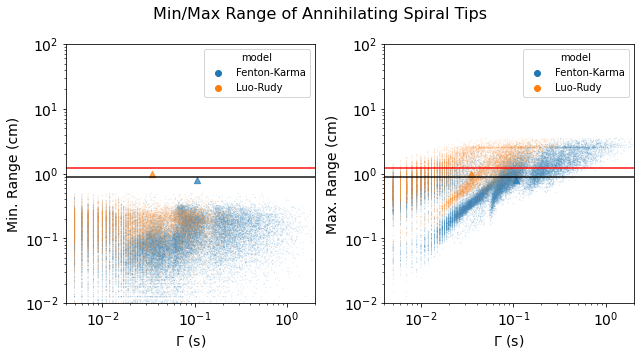

In [243]:
#TODO: substitute those first "all-together" averages in a new plot
#heretim
#show non-ergodicity
# print(f"All Observations Averaged Together Agrees Better:")
kwargs_scatter=dict(style=None, s=1,#10,#size=10, palette=None, hue_order=None, hue_norm=None, 
                #sizes=None, size_order=None, size_norm=None, 
                #markers=True, style_order=None, x_bins=None, y_bins=None, 
                #units=None, estimator=None, ci=95, n_boot=1000, 
                alpha=0.2, x_jitter=None, y_jitter=None, legend='auto')

use_loglog=True
fontsize=14

#plot the desired kinematic statistics panels on a log-log axis for both full models
#indicating expected alinear versus lifetime for both of the full models on a loglog plot
fig,axs=plt.subplots(figsize=(9,5),ncols=2)
#plot first radial moments
ax=axs[0] 
sns.scatterplot(x='lifetime', y='minR', hue='model', ax=ax,
                data=df_events, **kwargs_scatter)
#plot second radial moments
ax=axs[1] 
sns.scatterplot(x='lifetime', y='maxR', hue='model', ax=ax,
                data=df_events, **kwargs_scatter)
#plot alinear expected from simulated annealing
alinear_expected_fk = 1.9252  #cm^2/s
alinear_expected_lr = 11.2437 #cm^2/s
# alinear_expected_fk = 1.9252  -0.2#cm^2/s  # --> adj for D has little effect 
# alinear_expected_lr = 11.2437 -0.8#cm^2/s  # --> adj for D has little effect 
Rlinear_fk=np.sqrt(alinear_expected_fk*4*Gamma_fk)
Rlinear_lr=np.sqrt(alinear_expected_lr*4*Gamma_lr)
xv=np.logspace(-3,1.1,100)
axs[0].plot(xv,0.*xv+Rlinear_fk,'k-',lw=2,alpha=0.7)
axs[0].plot(xv,0.*xv+Rlinear_lr,'r-',lw=2,alpha=0.7)
axs[1].plot(xv,0.*xv+Rlinear_fk,'k-',lw=2,alpha=0.7)
axs[1].plot(xv,0.*xv+Rlinear_lr,'r-',lw=2,alpha=0.7)
print(f"{alinear_expected_fk=:.4f} cm^2/s (black)")
print(f"{alinear_expected_lr=:.4f} cm^2/s (red)")
print(f"--> {Rlinear_fk=:.4f} cm (black line)")
print(f"--> {Rlinear_lr=:.4f} cm (red line)")
#plot the ensemble averages
print(f"symbols indicate overall averages for (blue) FK and (orange) LR.")
# print(f"indicated are estimators from (circles) mean range and (squares) mean squared range (pun intended).")
for ax in axs:
    ax.scatter([0.106320],[0.791299],c='C0',marker='^',s=40,alpha=0.7) #FK #R
    ax.scatter([0.034366],[1.002005],c='C1',marker='^',s=40,alpha=0.7) #LR #R
    
#     Ensemble averages for Fenton-Karma:
#            lifetime          minR          maxR
# mean       0.106320      0.112596      0.791299
# std        0.162272      0.077046      0.594510
# count  36179.000000  36179.000000  36179.000000

# Ensemble averages for Luo-Rudy:
#            lifetime          minR          maxR
# mean       0.034366      0.164004      1.002005
# std        0.045084      0.088765      0.721659
# count  15273.000000  15273.000000  15273.000000
    
#format plot
format_plot(ax=axs[0],xlabel=r'$\Gamma$ (s)',ylabel=r'Min. Range (cm)', use_loglog=use_loglog, fontsize=fontsize)
format_plot(ax=axs[1],xlabel=r'$\Gamma$ (s)',ylabel=r'Max. Range (cm)', use_loglog=use_loglog, fontsize=fontsize)
axs[0].axis([4e-3,2,1e-2,1e2])
axs[1].axis([4e-3,2,1e-2,1e2])
fig.suptitle('Min/Max Range of Annihilating Spiral Tips',fontsize=fontsize+2)
plt.tight_layout()
plt.show()

In [244]:
#TODO: thumb through the results of the rstar_settings runs, plotting the original mean collision times


In [201]:
#note the similarity for FK when comparing MSR avg to Rbar avgs....
amax_fk_1=1.9252 #sim anneal #time-then-ensemble (MSR avg with exponential sampling)
amax_fk_2=1.932  #all together - average observation
amax_fk_3=1.916151  #time-then-ensemble (Rbar = mean range for given event)


#note the disimilarity for LR...
amax_fk_1=11.2437 #sim anneal #ensemble-then-time avg
amax_fk_2=8.63  #all together avg
amax_fk_3=7.212652  #time-then-ensemble avg (Rbar = mean range for given event)



In [110]:
# #HINT: visualize R(t) of a given event group, g
# fpr trial_num,annihilation_index,... in groups...
# t_values = g['tdeath'].values.copy()
# R_values = g['R'].values.copy()
# plt.plot(t_values,R_values)
# #plot alinear for this trajectory
# R_values
# #comparably plot alinear_expected for this trajectory
# plt.axis([0,6,0,.6])

In [ ]:
#DONT: identify events that may be messing up the average

In [111]:
#DONT: print mean alinear estimators with and without the selected cohort of ne'er-do-wells.

In [179]:
#DONT: Q: if i subtract off Rmin instead of adding tshift=DT, do alinear clouds tighten up? 

In [ ]:

# compute mean minimum lifetime
minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
printing=True
if printing:
    print(f" - o - mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
Gamma=float(meanx)
meanrange_values = df.groupby(by=['trial_num','annihilation_index'])['R'].mean().values
meanR,Delta_meanR,num_obsR,p_normalR=comp_mean_bootstrap_uncertainty(meanrange_values)
printing=True
if printing:
    print(f"averages for spiral tip pairs:")
    print(f" - x - particle average first (not this one!): mean range: {meanR:.4f} +/- {Delta_meanR:.4f} ms (N={num_obsR}, p_normal: {p_normalR:.4f}) from {num_termination_events} termination events")
# meanrange_values = df['R'].values
# meanR,Delta_meanR,num_obsR,p_normalR=comp_mean_bootstrap_uncertainty(meanrange_values)
# if printing:
#     print(f" - o - all positions together (use this one!): mean range: {meanR:.4f} +/- {Delta_meanR:.4f} ms (N={num_obsR}, p_normal: {p_normalR:.4f}) from {num_termination_events} termination events")
# meanSR,Delta_meanSR,num_obsSR,p_normalSR=comp_mean_bootstrap_uncertainty(meanrange_values**2)
# if printing:
#     print(f" - o - all positions together (use this one!): root mean squared range: {np.sqrt(meanSR):.4f} +/- {0.5*np.sqrt(Delta_meanSR)/np.sqrt(meanSR):.4f} ms (N={num_obsSR}, p_normal: {p_normalSR:.4f}) from {num_termination_events} termination events")


In [ ]:
# #HINT: visualize a given group, g
# trial_num,annihilation_index
# t_values = g['tdeath'].values.copy()
# R_values = g['R'].values.copy()
# #DONE: compute first order tshift bounded between 0 and 1
# #NOTE: first test case had tshift>1.  this lead to 6 months of confusion in the past... make no adjustment to R or time!
# # tshift=0.
# # # if R_values[0]>0:
# # #     #tshift=(t_values[1]-t_values[0])*(R_values[1]-R_values[0])/R_values[0]
# # #     #tshift=(t_values[1]-t_values[0])*R_values[0]/(R_values[1]-R_values[0])
# # #     tshift=(t_values[1]-t_values[0])*np.sqrt(R_values[0]/(R_values[1]-R_values[0]))
# # #     t_values+=tshift

# plt.plot(t_values,R_values)
# #plot alinear for this trajectory
# R_values
# #comparably plot alinear_expected for this trajectory
# plt.axis([0,6,0,.6])

# back of envelop estimation of amax

In [21]:
#TODO: dev run #30 (L=5) (and #31 (L=10)) using the following:
###########################
# mean min lifetime: Gamma
###########################
tscale=1e-3 #s per ms
lifetime_fk= 105.3 # (1.6) ms
lifetime_lr= 33.37 # (73) ms
Gamma_fk = lifetime_fk*tscale
Gamma_lr = lifetime_lr*tscale

###########################
# rms range: Gamma
###########################
R_rms_fk = 0.67 # ± 0.06 cm
R_rms_lr = 0.86 # ± 0.07 cm

######################################################
# max attraction coefficient: amax (Method 1, b.o.e.)
######################################################
mean_squared_distance_fk = R_rms_fk**2
mean_squared_distance_lr = R_rms_lr**2
alinear_boe_fk = (mean_squared_distance_fk / Gamma_fk) / 4
alinear_boe_lr = (mean_squared_distance_lr / Gamma_lr) / 4
alinear_boe_fk,alinear_boe_lr

(1.0657644824311492, 5.540905004495055)

In [31]:
############################
# mean rotational period: T
############################
# #src: http://localhost:8889/notebooks/computing%20rotational%20period%20of%20mean%20fortranic%20spiral%20trajectories.ipynb
# - LR: mean number of loops per particle lifetime: 0.3438
# - FK: mean number of loops per particle lifetime: 0.4976
# - FK(backup, failing ^that): mean number of loops per particle lifetime (at least 1 loop): 0.9131
# T_fk = Gamma_fk / 0.4976 # looks about 2X wrong... 
T_fk = Gamma_fk / 0.9131
T_lr = Gamma_lr / 0.3438
T_lr=1e-3*104.92 #result from unconstrained simulated annealing
print(f"{T_fk=:.4f} s")
print(f"{T_lr=:.4f} s")

T_fk=0.1153 s
T_lr=0.1049 s


In [32]:
#print back of envelope estimates for alinear for each of the estimates of the mean squared distance between spiral tips
######################################################
# max attraction coefficient: amax (Method 1, b.o.e.)
######################################################

mean_squared_distance_fk =  0.9022**2
mean_squared_distance_lr = 1.0733**2
# mean_squared_distance_fk =  0.5263**2
# mean_squared_distance_lr = 0.6635**2
# mean_squared_distance_fk =  1.1521
# mean_squared_distance_lr = 1.6040
# mean_squared_distance_fk = R_rms_fk**2
# mean_squared_distance_lr = R_rms_lr**2
alinear_boe_fk = (mean_squared_distance_fk / Gamma_fk) / 4
alinear_boe_lr = (mean_squared_distance_lr / Gamma_lr) / 4
print(f"{alinear_boe_fk=:.4f} cm^2/s")
print(f"{alinear_boe_lr=:.4f} cm^2/s")

alinear_boe_fk=1.9325 cm^2/s
alinear_boe_lr=8.6303 cm^2/s


# estimate alinear for fixed period 
NOTE: this doesn't seem to work with the apparent period....

In [33]:
#####################
# Fenton-Karma
#####################
range_data_dir_lst=[
    f'{nb_dir}/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl',
    f'{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl',    
#     '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl',
#     '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl',    
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl',
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl',    
]

# #####################
# # Luo-Rudy
# #####################
#runtime ~13 minutes
# range_data_dir_lst=[
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl',
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/250x250/tippos_per_c_001_annihilation_range_timeseries.pkl',
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/300x300/tippos_per_c_001_annihilation_range_timeseries.pkl',
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/350x350/tippos_per_c_001_annihilation_range_timeseries.pkl',
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/400x400/tippos_per_c_001_annihilation_range_timeseries.pkl',
#     #'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/500x500/tippos_per_001_annihilation_range_timeseries.pkl',
#     #^this one is too big to track in a reasonable amount of time...     
# ]
for fn in range_data_dir_lst:
    print(f"{fn}")
    assert os.path.exists(fn)
print(f"^those exist")

/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl
/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl
^those exist


In [34]:
#HINT: sim. anneal routine that calculates amax unconstrained
# max_tdeath=100. #ms #LR
max_tdeath=300. #ms FK
printing=True
D=0
use_sim_anneal=True
repeat_w_10X=True

In [41]:
tshift

0.005060478785636687

In [42]:
#DONE: recall rotational period, T in seconds
max_tdeath_lst=[300.,100.,] #ms
T_lst=[T_fk,T_lr] #s

dict_fit_lst=[]
msr_dir_bootstrap_fk = f'{nb_dir}/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
msr_dir_bootstrap_lr = f'{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv'
# msr_dir_bootstrap_fk = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
# msr_dir_bootstrap_lr = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv'
msr_dir_bootstrap_lst=[msr_dir_bootstrap_fk,msr_dir_bootstrap_lr]
print(f"printing for two file sets: FK and then LR...")
# for max_tdeath,T,range_data_dir in zip(reversed(max_tdeath_lst),reversed(T_lst),reversed(range_data_dir_lst)):
for max_tdeath,T,range_data_dir,msr_dir_bootstrap in zip(max_tdeath_lst,T_lst,range_data_dir_lst,msr_dir_bootstrap_lst):
    #DONE: dev sim. anneal routine that calculates amax constrained to T.
    # #DONE: perform simulated annealing
    # #input: T, Gamma, MSR(t'), D=0
    # #output: mean squared distance
    # for range_data_dir in range_data_dir_lst:
    print(f"\n{range_data_dir=}")
    data_lst=load_from_pickle(range_data_dir)
    num_termination_events = len(data_lst)
    print(f"loaded range timeseries from {len(data_lst)} termination events")

    df=pd.concat(data_lst)
    del data_lst
    print(f"{df.shape=}")
    # compute mean minimum lifetime
    minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
    meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
    printing=True
    if printing:
        print(f" - o - mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
    Gamma=float(meanx)
    meanrange_values = df.groupby(by=['trial_num','annihilation_index'])['R'].mean().values
    meanR,Delta_meanR,num_obsR,p_normalR=comp_mean_bootstrap_uncertainty(meanrange_values)
    printing=True
    if printing:
        print(f"averages for spiral tip pairs:")
        print(f" - x - particle average first: mean range: {meanR:.4f} +/- {Delta_meanR:.4f} ms (N={num_obsR}, p_normal: {p_normalR:.4f}) from {num_termination_events} termination events")
        #print(f" - x - particle average first: mean range: {meanR:.4f} +/- {Delta_meanR:.4f} ms (N={num_obsR}, p_normal: {p_normalR:.4f}) from {num_termination_events} termination events")
    #     print(f" - x - particle average first (not this one!): mean range: {meanR:.4f} +/- {Delta_meanR:.4f} ms (N={num_obsR}, p_normal: {p_normalR:.4f}) from {num_termination_events} termination events")
    meanrange_values = df['R'].values
#     meanR,Delta_meanR,num_obsR,p_normalR=comp_mean_bootstrap_uncertainty(meanrange_values)
#     if printing:
#         print(f" - o - all positions together (use this one!): mean range: {meanR:.4f} +/- {Delta_meanR:.4f} ms (N={num_obsR}, p_normal: {p_normalR:.4f}) from {num_termination_events} termination events")
#     meanSR,Delta_meanSR,num_obsSR,p_normalSR=comp_mean_bootstrap_uncertainty(meanrange_values**2)
#     if printing:
#         print(f" - o - all positions together (use this one!): root mean squared range: {np.sqrt(meanSR):.4f} +/- {0.5*np.sqrt(Delta_meanSR)/np.sqrt(meanSR):.4f} ms (N={num_obsSR}, p_normal: {p_normalSR:.4f}) from {num_termination_events} termination events")
#         print(f" - o - all positions together (use this one!): mean squared range: {meanSR:.4f} +/- {Delta_meanSR:.4f} ms (N={num_obsSR}, p_normal: {p_normalSR:.4f}) from {num_termination_events} termination events")
    if printing:
        print(f"loading bootstrapped mean...")
    df_bootstrap = pd.read_csv(msr_dir_bootstrap)
    x_values=df_bootstrap['tdeath_avg'].values
    y_values=df_bootstrap['MSR'].values
    yerr_values=df_bootstrap['Delta_MSR'].values
    x_values.shape,y_values.shape,yerr_values.shape
    # optionally fit alinear with simulated annealing
    # select msr from the full models for fitting
    boo=x_values<max_tdeath
    t_values=x_values[boo].copy()*1e-3
    
    #     #shift time forward by one time step
    #     tshift = t_values[1]-t_values[0]
    #     t_values+=tshift
    
    msr_values=y_values[boo].copy() 
    # msr_values-= np.min(msr_values) #rmse = 0.58  with this uncommented
    #rmse = 0.66  with zero not subtracted.  also alinear was larger for LR model
    maxiter=10000
    print(f"running simulated annealing for {maxiter} epochs...")
    # bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15))
    bounds = ((0, 1.), (0, 10000.), (-3.15,3.15))
#     bounds = ((0, 1.), (0, 10000.), (-3.15,3.15), (-2.,2.))
    # msr_dir_bootstrap = msr_dir_bootstrap_lr
    print(f"{max_tdeath=} ms")
    print(f"src: {msr_dir_bootstrap=}")
    if use_sim_anneal:
        maxiter=10000
        print(f"num. epochs: {maxiter}")
        #x0=a0,a1,phase
        period=T*1e3 #bc period is in milliseconds
        args=t_values,msr_values,D,period
        res = dual_annealing(comp_square_error_msr_aff_osc_period_fixed,#comp_square_error_msr_aff_osc_period_fixed_with_msr_offset,#
                    bounds=bounds,
                    args=args,
                   maxiter=maxiter,seed=42,
                   no_local_search=True)#,**kwargs)

        rmse= np.sqrt(res.fun/t_values.shape[0])
        #a0,a1,phase,MSR_offset=res.x
        MSR_offset=0.
        a0,a1,phase=res.x
        print(f"simulated annealing fit: {a0=:.9f}, {a1=:.9f}, {period=:.9f}, {phase=:.9f} , {MSR_offset=:.4f} --> {rmse=:.9f} cm^2")

        alinear = comp_alinear(a0,a1,period,Gamma,phase)
        omega = 2*np.pi/period
        z = Gamma*omega
        print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
        print(f">>> {alinear=} \n")
        #print(f"*************** end data set ********************")

        if repeat_w_10X:
            #optionally repeat at 10X number of epochs
            maxiter=100000
            print(f"running simulated annealing for {maxiter} epochs...")
            #x0=a0,a1,phase
            #period=T*1e3 #bc period is in milliseconds
            #args=t_values,msr_values,D,period
            res = dual_annealing(comp_square_error_msr_aff_osc_period_fixed,#comp_square_error_msr_aff_osc_period_fixed_with_msr_offset,#
                        bounds=bounds,
                        args=args,
                       maxiter=maxiter,seed=42,
                       no_local_search=True)#,**kwargs)

            rmse= np.sqrt(res.fun/t_values.shape[0])
            #a0,a1,phase,MSR_offset=res.x
            MSR_offset=0.
            a0,a1,phase=res.x
            print(f"simulated annealing fit: {a0=:.9f}, {a1=:.9f}, {period=:.9f}, {phase=:.9f} --> {rmse=:.9f} cm^2")

            alinear = comp_alinear(a0,a1,period,Gamma,phase)
            omega = 2*np.pi/period
            z = Gamma*omega
            print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
            print(f">>> {alinear=} \n")
            print(f"*************** end data set ********************")
            dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,MSR_offset=MSR_offset,
              alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
        #record
        dict_fit_lst.append(dict_fit)

printing for two file sets: FK and then LR...

range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'
loaded range timeseries from 80 termination events
df.shape=(3846532, 9)
 - o - mean lifetime: 105.3196 +/- 1.6700 ms (N=36179, p_normal: 0.2763) from 80 termination events
averages for spiral tip pairs:
 - x - particle average first: mean range: 0.5263 +/- 0.0036 ms (N=36179, p_normal: 0.1609) from 80 termination events
loading bootstrapped mean...
running simulated annealing for 10000 epochs...
max_tdeath=300.0 ms
src: msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
num. epochs: 10000
simulated annealing fit: a0=0.702539262, a1=1.567524936, period=115.321432483, phase=-0.750224650 , MSR_offset=0.0000 --> rmse=0.047952935 cm^2
	attraction coefficient: a0=0.7025, a1=1.5675, z=5.7382, phase=-0.7

In [43]:
dict_osc_fit_fk=dict(dict_fit_lst[0])
dict_osc_fit_lr=dict(dict_fit_lst[1])

In [44]:
df_msr_fk=pd.read_csv(msr_dir_bootstrap_fk)
df_msr_lr=pd.read_csv(msr_dir_bootstrap_lr)


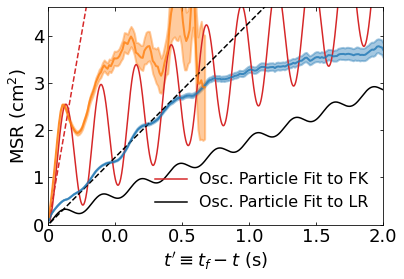

In [45]:
#extract xy values from full
x_values_fk=df_msr_fk['tdeath_avg'].values
y_values_fk=df_msr_fk['MSR'].values
yerr_values_fk=df_msr_fk['Delta_MSR'].values
x_values_lr=df_msr_lr['tdeath_avg'].values
y_values_lr=df_msr_lr['MSR'].values
yerr_values_lr=df_msr_lr['Delta_MSR'].values


#plot MSR_Osc over the direct simulation results
lw=2
alpha=0.4
# fontsize=16
fontsize=18
# # figsize=(8,4.2)
# figsize=(4,4.2)
figsize=(6,4)
# fontsize=15
### plot expected
# fontsize=20
tscale=1e-3

fig,ax=plt.subplots(figsize=(6,4))
#plot simulated annealing fits of oscillatory particle model
MSR_offset=dict_osc_fit_lr['MSR_offset']
phi_f = dict_osc_fit_lr['phase']
omega = dict_osc_fit_lr['omega']*1e3
a = dict_osc_fit_lr['a1']
D = dict_osc_fit_lr['a0']/2
t_values=np.linspace(0,1,1000)

t_values+=tshift

# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f))) + MSR_offset
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'Osc. Particle Fit to FK')
#                 label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')
phi_f = dict_osc_fit_fk['phase']
omega = dict_osc_fit_fk['omega']*1e3
a = dict_osc_fit_fk['a1']
D = dict_osc_fit_fk['a0']/2
# t_values=np.linspace(0,1,1000)
MSR_offset=dict_osc_fit_fk['MSR_offset']
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))+MSR_offset
ax.plot(t_values,MSR_values_oscillatory,c='k',#'C2',
                label=r'Osc. Particle Fit to LR')

#plot the linear particle model
amax_fk = 1.781
amax_lr = 10.147
ax.plot(t_values,4*amax_fk*t_values,c='k',linestyle='dashed')
ax.plot(t_values,4*amax_lr*t_values,c='C3',linestyle='dashed')
# ax.plot(t_values,4*amax_fk*t_values,c='C0',linestyle='dashed')
# ax.plot(t_values,4*amax_lr*t_values,c='C1',linestyle='dashed')

# #plot the direct simulation of the oscillatory particle model under these same parameter settings
# stepsize=2500
# plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='k',#'C2',
#             marker='x')#,label='Simulation of Osc. (FK)')
# stepsize=1000
# plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C3',
#             marker='x')#,label='Simulation of Osc. (LR)')

#plot msd data from full
ax.plot(x_values_fk*tscale,y_values_fk,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,lw=lw,alpha=alpha,color='C0')
ax.plot(x_values_lr*tscale,y_values_lr,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_lr*tscale,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,lw=lw,alpha=alpha,color='C1')

#format_plot
# format_plot(ax=ax,xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r"$t'\equiv t_f-t$ (s)",ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
ax.tick_params(bottom=True,left=True,top=True, right=True,direction='in',which='both')
ax.legend(fontsize=16,frameon=False)
xticklabels = [str(x) for x in ax.get_xticks()]
xticklabels[0] = '0'
ax.set_xticklabels(xticklabels)
plt.xlim([0,1])
plt.ylim([0,4.6])
# plt.ylim([0,5.1])
# plt.ylim([0,14.1])
plt.show()

In [27]:
# >>> alinear=1.8402023397115908 
# >>> alinear=8.585030312541999 


In [28]:
# alinear_anneal_fk = 1.8402023397115908 
# alinear_anneal_lr = 8.585030312541999 

In [29]:
# x0=a0,a1,phase
# period=T*1e3 #bc period is in milliseconds
# args=t_values,msr_values,D,period
# square_error=comp_square_error_msr_aff_osc_period_fixed(x0,*args)
# rmse=np.sqrt(square_error/t_values.shape[0])
# print(f"{rmse=}")

In [30]:
# # ######################################################
# # # TODO: max attraction coefficient: amax (Method 2, annealed)
# # ######################################################
# # mean_squared_distance_hat_fk = ??
# # mean_squared_distance_hat_lr = ??
# # alinear_anneal_fk = mean_squared_distance_hat_fk / Gamma_fk / 4
# # alinear_anneal_lr = mean_squared_distance_hat_lr / Gamma_lr / 4
# #TODO: compare ibid to 
# alinear_boe_fk = mean_squared_distance_fk / Gamma_fk / 4
# alinear_boe_lr = mean_squared_distance_lr / Gamma_lr / 4
# print(f"{alinear_anneal_fk=} cm^2/s")
# print(f"{alinear_boe_fk=} cm^2/s")
# print(f"{alinear_anneal_lr=} cm^2/s")
# print(f"{alinear_boe_lr=} cm^2/s")

In [31]:
#TODO: dev next data run #30!
#TODO: play in midas for the remainder of the evening...

In [32]:
# ######################################################
# # diffusion coefficient: D (from time averaged MSD)
# ######################################################
# $D$ (cm$^2$/s):
# - FK: 37.2$\pm$1.4$\times10^{-3}$
# - LR: 1.40$\pm$0.10$\times10^{-3}$
# - FK(failing ^that, from MSR): D = m/8 = 0.1145 +/- 0.007987364738330576 (using timepoints after 600.0 ms)

# ######################################################
# # reaction rate: kappa (b.o.e. from death rates and qs distribution)
# ######################################################
# - Area: 25 cm^2, kappa: 436.74 Hz (Fenton-Karma)
# - Area: 25 cm^2, kappa: 1614.16 Hz (Luo-Rudy)
# - Area: 100 cm^2, kappa: 6197.13 Hz (Fenton-Karma)
# - Area: 100 cm^2, kappa: 8532.76 Hz (Luo-Rudy)

# then, TODO: dev run #30 using the above parameter values

In [33]:
# # # Compute MSR(t') by averaging range timeseries
# # x_values_in=df['tdeath'].values
# # y_values_in=df['R'].values**2
# # print(f"tdeath ranges from {np.min(x_values_in)} to {np.max(x_values_in)} ms")
# # print(f"R^2 ranges from {np.min(y_values_in)} to {np.max(y_values_in)} cm^2")

# # assert not np.isnan(x_values_in).any() 
# # assert not np.isnan(y_values_in).any()

# # #compute bootstrap 
# # printing=True
# # if printing:
# #     print(f"loading bootstrapped mean...")
# # #     print(f"bootstrapping mean (estimated run time ~30 seconds)...")
# # # bins=np.arange(0,450,1)
# # # bins=np.arange(0,1800,5)
# # bins=np.arange(0,2800,5)
# # df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,
# #                                y_values_in,
# #                                xlabel='tdeath_avg',
# #                                ylabel='MSR',
# #                                bins=bins,
# #                                min_numobs=10,
# #                                num_bootstrap_samples=1000,
# #                                npartitions=10,
# #                                use_test=False)
# # #save msr as .csv
# # msr_dir_bootstrap=range_data_dir.replace('_range_timeseries.pkl','_msr.csv')
# # df_bootstrap.to_csv(msr_dir_bootstrap,index=False)
# # print(f"{msr_dir_bootstrap=}")

# # if printing:
# #     print(f"loading bootstrapped mean...")
# df_bootstrap = pd.load_csv(msr_dir_bootstrap)

# x_values=df_bootstrap['tdeath_avg'].values
# y_values=df_bootstrap['MSR'].values
# yerr_values=df_bootstrap['Delta_MSR'].values
# x_values.shape,y_values.shape,yerr_values.shape


# # optionally fit alinear with simulated annealing
# # select msr from the full models for fitting
# boo=x_values<max_tdeath
# t_values=x_values[boo].copy()*1e-3
# msr_values=y_values[boo].copy() 
# msr_values-= np.min(msr_values)
# print(f"{max_tdeath=} ms")
# print(f"src: {msr_dir_bootstrap=}")
# if use_sim_anneal:
#     maxiter=10000
#     print(f"num. epochs: {maxiter}")
#     res = anneal_msr_fit(t_values,msr_values,D,
#                        bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
#                        maxiter=maxiter,seed=42, no_local_search=True)#,**kwargs)
#     rmse= np.sqrt(res.fun/t_values.shape[0])
#     a0,a1,period,phase=res.x
#     #print(f"simulated annealing fit: {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f} --> {rmse=:.4f} cm^2")

#     alinear = comp_alinear(a0,a1,period,Gamma,phase)
#     omega = 2*np.pi/period
#     z = Gamma*omega
#     print(f"\tsimulated annealing fit: {a0=:.9f}, {a1=:.9f}, {z=:.9f}, {phase=:.9f} --> {alinear=:.9f} cm^2/s")
#     print(f">>> {alinear=} \n")    
#     if repeat_w_10X:
#         #optionally repeat at 10X number of epochs
#         maxiter=100000
#         print(f"running simulated annealing for {maxiter} epochs...")
#         bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15))
        
#         #x0=a0,a1,phase
#         period=T*1e3 #bc period is in milliseconds
#         args=t_values,msr_values,D,period
#         res = dual_annealing(comp_square_error_msr_aff_osc
#                    ,
#                    maxiter=maxiter,seed=42,
#                    no_local_search=True)#,**kwargs)
        
            
#     # np.random.seed(42)   # seed to allow replication.
#     res = dual_annealing(
#         comp_square_error_msr_aff_osc,
#         bounds=bounds,
#         args=args,
#         maxiter=maxiter,
#         seed=seed,
#         no_local_search=no_local_search,**kwargs)
        
        
        
        
        
        
        
#         res = anneal_msr_fit(t_values,msr_values,D,
#                            bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
#                            maxiter=maxiter,seed=42+1, no_local_search=True)#,**kwargs)
#         rmse= np.sqrt(res.fun/t_values.shape[0])
#         a0,a1,period,phase=res.x
#         print(f"simulated annealing fit: {a0=:.9f}, {a1=:.9f}, {period=:.9f}, {phase=:.9f} --> {rmse=:.9f} cm^2")

#         alinear = comp_alinear(a0,a1,period,Gamma,phase)
#         omega = 2*np.pi/period
#         z = Gamma*omega
#         print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
#         print(f">>> {alinear=} \n")
#         print(f"*************** end data set ********************")

In [37]:
#compute minlifetime_values
minlifetime_values_fk = df_ranges_fk.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values_fk)
printing=True
if printing:
    print(f" - FK: mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events_fk} termination events")
    
minlifetime_values_lr = df_ranges_lr.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values_lr)
printing=True
if printing:
    print(f" - LR: mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events_lr} termination events")
    

 - FK: mean lifetime: 105.3196 +/- 1.6957 ms (N=36179, p_normal: 0.1561) from 80 termination events
 - LR: mean lifetime: 33.3659 +/- 0.7189 ms (N=15273, p_normal: 0.4168) from 595 termination events


In [38]:
##################################################################
# compute simulated annealing fits of oscillatory particle model
##################################################################
D=0.
print(f"fixed {D=:.4f} cm^2/s.")
print(f"computing simulated annealing fits of oscillatory particle model to the Fenton-Karma model...")
# select msr from the full models for fitting
x_values=x_values_fk.copy()
y_values=y_values_fk.copy()
minlifetime_values=minlifetime_values_fk.copy()

#### 

# max_tdeath=100. #ms #for lr
max_tdeath=300. #ms #for fk
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
Gamma=float(meanx)
# testing=False 
testing=True # True adds ~60 - 6.27 seconds to runtime
if printing:
    print(f"mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {minlifetime_values.shape[0]} observations")
#fit using simulated annealing
a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                    D=0.,maxiter=10000,seed=42,printing=printing)
alinear = comp_alinear(a0,a1,period,Gamma,phase)
omega = 2*np.pi/period
z = Gamma*omega
print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,MSR_offset=0.,
              alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
if not testing:
    print_dict(dict_fit)

if testing:
    print(f"performing fit using simulated annealing with 10X the number of learning rounds...")
    a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                        D=0.,maxiter=100000,seed=43,printing=printing)
    alinear = comp_alinear(a0,a1,period,Gamma,phase)
    omega = 2*np.pi/period
    z = Gamma*omega
    print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
    dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,MSR_offset=0.,
                  alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
    print_dict(dict_fit)    
    
dict_osc_fit_fk=dict(dict_fit)

#### 
print(f"\ncomputing simulated annealing fits of oscillatory particle model to the Luo-Rudy model...")
# select msr from the full models for fitting
x_values=x_values_lr.copy()
y_values=y_values_lr.copy()
minlifetime_values=minlifetime_values_lr.copy()
max_tdeath=100. #ms #for lr
# max_tdeath=300. #ms #for fk
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
Gamma=float(meanx)
# testing=False 
# testing=True # True adds ~60 - 6.27 seconds to runtime
if printing:
    print(f"mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {minlifetime_values.shape[0]} observations")
#fit using simulated annealing
a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                    D=0.,maxiter=10000,seed=42,printing=printing)
alinear = comp_alinear(a0,a1,period,Gamma,phase)
omega = 2*np.pi/period
z = Gamma*omega
print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,MSR_offset=0.,
              alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
if not testing:
    print_dict(dict_fit)

if testing:
    print(f"performing fit using simulated annealing with 10X the number of learning rounds...")
    a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                        D=0.,maxiter=100000,seed=43,printing=printing)
    alinear = comp_alinear(a0,a1,period,Gamma,phase)
    omega = 2*np.pi/period
    z = Gamma*omega
    print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
    dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,MSR_offset=0.,
                  alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
    print_dict(dict_fit)    

dict_osc_fit_lr=dict(dict_fit)


fixed D=0.0000 cm^2/s.
computing simulated annealing fits of oscillatory particle model to the Fenton-Karma model...
mean lifetime: 105.3196 +/- 1.6518 ms (N=36179, p_normal: 0.7491) from 36179 observations
performing simulated annealing with D=0 fixed (num. epochs: 10000)...
simulated annealing fit: a0=1.6362, a1=1.2822, period=115.9413, phase=-0.5415 --> rmse=0.0284 cm^2
	attraction coefficient: a0=1.6362, a1=1.2822, z=5.7076, phase=-0.5415 --> alinear=1.7812 cm^2/s
performing fit using simulated annealing with 10X the number of learning rounds...
performing simulated annealing with D=0 fixed (num. epochs: 100000)...
simulated annealing fit: a0=1.6362, a1=1.2823, period=115.9535, phase=-0.5407 --> rmse=0.0284 cm^2
	attraction coefficient: a0=1.6362, a1=1.2823, z=5.7070, phase=-0.5407 --> alinear=1.7811 cm^2/s
a0=1.6361682120621026
a1=1.2823348299592112
period=115.9534730283433
phase=-0.5406748462891398
rmse=0.02843378899909942
MSR_offset=0.0
alinear=1.7811283375808102
omega=0.0541871

# TODO: visualize the plots

In [39]:
#load from full models

#load msr data for FK model (200x200) (src: wj)
msr_dir_bootstrap_fk=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
range_data_dir_fk=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'
# msr_dir_bootstrap_fk=f'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
# range_data_dir_fk=f'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'
df_msr_fk=pd.read_csv(msr_dir_bootstrap_fk)
#load apparent ranges
data_lst=load_from_pickle(range_data_dir_fk)
num_termination_events_fk = len(data_lst)
print(f"loaded range timeseries from {num_termination_events_fk} termination events (FK)")
df_ranges_fk=pd.concat(data_lst)
del data_lst
print(f"{df_ranges_fk.shape=}")

#load msr data for LR model (200x200) (src: wj)
msr_dir_bootstrap_lr=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv'
range_data_dir_lr=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl'
# msr_dir_bootstrap_lr=f'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv'
# range_data_dir_lr=f'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl'
df_msr_lr=pd.read_csv(msr_dir_bootstrap_lr)
#load apparent ranges
data_lst=load_from_pickle(range_data_dir_lr)
num_termination_events_lr = len(data_lst)
print(f"loaded range timeseries from {num_termination_events_lr} termination events (LR)")
df_ranges_lr=pd.concat(data_lst)
del data_lst
print(f"{df_ranges_lr.shape=}")

loaded range timeseries from 80 termination events (FK)
df_ranges_fk.shape=(3846532, 9)
loaded range timeseries from 595 termination events (LR)
df_ranges_lr.shape=(524869, 9)


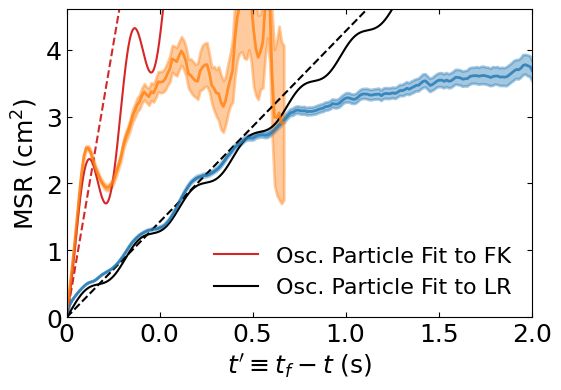

In [40]:
#extract xy values from full
x_values_fk=df_msr_fk['tdeath_avg'].values
y_values_fk=df_msr_fk['MSR'].values
yerr_values_fk=df_msr_fk['Delta_MSR'].values
x_values_lr=df_msr_lr['tdeath_avg'].values
y_values_lr=df_msr_lr['MSR'].values
yerr_values_lr=df_msr_lr['Delta_MSR'].values


#plot MSR_Osc over the direct simulation results
lw=2
alpha=0.4
# fontsize=16
fontsize=18
# # figsize=(8,4.2)
# figsize=(4,4.2)
figsize=(6,4)
# fontsize=15
### plot expected
# fontsize=20
tscale=1e-3

fig,ax=plt.subplots(figsize=(6,4))
#plot simulated annealing fits of oscillatory particle model
MSR_offset=dict_osc_fit_lr['MSR_offset']
phi_f = dict_osc_fit_lr['phase']
omega = dict_osc_fit_lr['omega']*1e3
a = dict_osc_fit_lr['a1']
D = dict_osc_fit_lr['a0']/2
t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f))) + MSR_offset
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'Osc. Particle Fit to FK')
#                 label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')
phi_f = dict_osc_fit_fk['phase']
omega = dict_osc_fit_fk['omega']*1e3
a = dict_osc_fit_fk['a1']
D = dict_osc_fit_fk['a0']/2
# t_values=np.linspace(0,1,1000)
MSR_offset=dict_osc_fit_fk['MSR_offset']
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))+MSR_offset
ax.plot(t_values,MSR_values_oscillatory,c='k',#'C2',
                label=r'Osc. Particle Fit to LR')

#plot the linear particle model
amax_fk = 1.781
amax_lr = 10.147
ax.plot(t_values,4*amax_fk*t_values,c='k',linestyle='dashed')
ax.plot(t_values,4*amax_lr*t_values,c='C3',linestyle='dashed')
# ax.plot(t_values,4*amax_fk*t_values,c='C0',linestyle='dashed')
# ax.plot(t_values,4*amax_lr*t_values,c='C1',linestyle='dashed')

# #plot the direct simulation of the oscillatory particle model under these same parameter settings
# stepsize=2500
# plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='k',#'C2',
#             marker='x')#,label='Simulation of Osc. (FK)')
# stepsize=1000
# plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C3',
#             marker='x')#,label='Simulation of Osc. (LR)')

#plot msd data from full
ax.plot(x_values_fk*tscale,y_values_fk,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,lw=lw,alpha=alpha,color='C0')
ax.plot(x_values_lr*tscale,y_values_lr,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_lr*tscale,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,lw=lw,alpha=alpha,color='C1')

#format_plot
# format_plot(ax=ax,xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r"$t'\equiv t_f-t$ (s)",ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
ax.tick_params(bottom=True,left=True,top=True, right=True,direction='in',which='both')
ax.legend(fontsize=16,frameon=False)
xticklabels = [str(x) for x in ax.get_xticks()]
xticklabels[0] = '0'
ax.set_xticklabels(xticklabels)
plt.xlim([0,1])
plt.ylim([0,4.6])
# plt.ylim([0,5.1])
# plt.ylim([0,14.1])
plt.show()